# Contextualized Modeling Tutorial: MNIST and Primes
Searching for prime numbers mathematically is difficult, maybe it's time for a different approach.
What non-math information could we incorporate, like the shape of a digit or someone's opinion about a digit?


Let's try this idea with contextualized models.


Suppose we have a dataset of handwritten digits, as well as the true digit label and primeness of that digit, and a qualitative survey about each handwritten digit where people have answered questions such as "does the digit have a straight line? Is the digit loopy/symmetrical/round/even? Is the digit good or evil?"


Naively relating these qualities to primeness with a simple model like logistic regression is wrong, because these qualities don't fully describe the digit (digits are not linearly separable by their qualities), and digits are the source of "primeness".


However, with the handwritten digit as context, we try to "contextualize" the primes/non-prime decision boundary. For instance, 1 is often written like 7, but 1 is symmetric and 7 is not, so the quality of symmetry can inform us about primeness.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

from contextualized.regression import RegressionTrainer, ContextualizedRegression
from contextualized.networks import NetworkTrainer, ContextualizedCorrelation

In [2]:
mnist_train = torchvision.datasets.MNIST('./data/', train=True, download=True)
mnist_test = torchvision.datasets.MNIST('./data/', train=True, download=True)

In [3]:
feature_names = ['straight line', 'loopy', 'symmetrical', 'round', 'even', 'good/evil']
def features(n):
    zero = [False, True, True, True, True]
    one = [True, False, True, False, False]
    two = [False, False, True, False, True]
    three = [False, False, True, False, False]
    four = [True, False, False, False, True]
    five = [True, False, False, False, False]
    six = [False, True, False, False, True]
    seven = [True, False, False, False, False]
    eight = [False, True, True, False, True]
    nine = [True, True, False, False, False]
    features = [zero, one, two, three, four, five, six, seven, eight, nine]
    opinion = bool(np.random.binomial(1, .5))
    return features[n] + [opinion]

label_names = ['prime']
def labels(n):
    zero =[False]
    one = [False]
    two = [True]
    three = [True]
    four = [False]
    five = [True]
    six = [False]
    seven = [True]
    eight = [False]
    nine = [False]
    features = [zero, one, two, three, four, five, six, seven, eight, nine]
    return features[n]

def load_data(dataset, size=np.inf):
    C, X, Y, vals = [], [], [], []
    for i, (img, val) in enumerate(dataset):
        if i >= size:
            break
        C.append(np.array(img).flatten())
        X.append(features(val))
        Y.append(labels(val))
        vals.append(val)
    return (np.array(C).astype(np.float32), 
            np.array(X).astype(np.float32), 
            np.array(Y).astype(np.float32),
            np.array(vals))
    
C_train, X_train, Y_train, vals_train = load_data(mnist_train, size=10000)
C_test, X_test, Y_test, vals_test = load_data(mnist_test, size=1000)
C_train.shape, C_test.shape

((10000, 784), (1000, 784))

In [4]:
C_mean, C_std = C_train.mean(axis=0), C_train.std(axis=0)
C_std[C_std == 0] = 1
C_train = (C_train - C_mean) / C_std
C_test = (C_test - C_mean) / C_std

X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
X_std[X_std == 0] = 1
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Contextualized Regression

In [6]:
mlp_kwargs = {
    'width': 25,
    'layers': 2,
    'link_fn': lambda x: torch.nn.functional.softmax(x, dim=1)
}
link_fn = lambda x: 1 / (1 + torch.exp(-x))
creg = ContextualizedRegression(
    C_train.shape[-1], 
    X_train.shape[-1], 
    Y_train.shape[-1],
    link_fn=link_fn,
    encoder_kwargs = mlp_kwargs,
)
train_dataloader = creg.dataloader(C_train, X_train, Y_train, batch_size=1)
test_dataloader = creg.dataloader(C_test, X_test, Y_test, batch_size=1)

In [7]:
trainer = RegressionTrainer(max_epochs=1)
trainer.fit(creg, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 20.0 K
-----------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing

Training: 0it [00:00, ?it/s]

In [8]:
y_pred = trainer.predict_y(creg, test_dataloader)
y_pred_label = y_pred > .5
print(f'Y prediction error: {(y_pred_label != Y_test).mean()}')

/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 9999it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Y prediction error: 0.01


In [9]:
def get_encodings(creg, C):
    encoder = creg.metamodel.context_encoder
    Z = encoder(C)
    return Z.detach()

def get_atoms(creg):
    x_dim = X_train.shape[-1]
    archetypes = creg.metamodel.explainer.softselect.archetypes.detach()[0, :x_dim]
    return archetypes

encodings = get_encodings(creg, torch.tensor(C_test))
betas, mus = trainer.predict_params(creg, test_dataloader)

Predicting: 9999it [00:00, ?it/s]

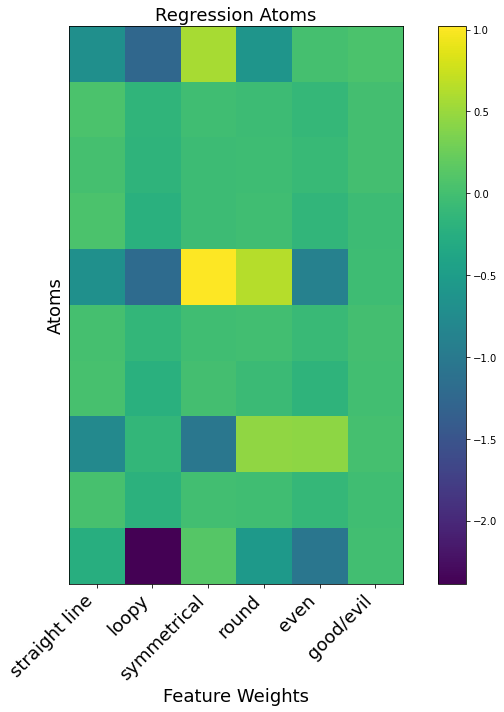

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(get_atoms(creg).T)
plt.colorbar()
plt.title('Regression Atoms', fontsize=18)
plt.ylabel('Atoms', fontsize=18)
plt.yticks([], fontsize=18)
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right', va='top', fontsize=18)
plt.xlabel('Feature Weights', fontsize=18)
plt.tight_layout()
plt.show()

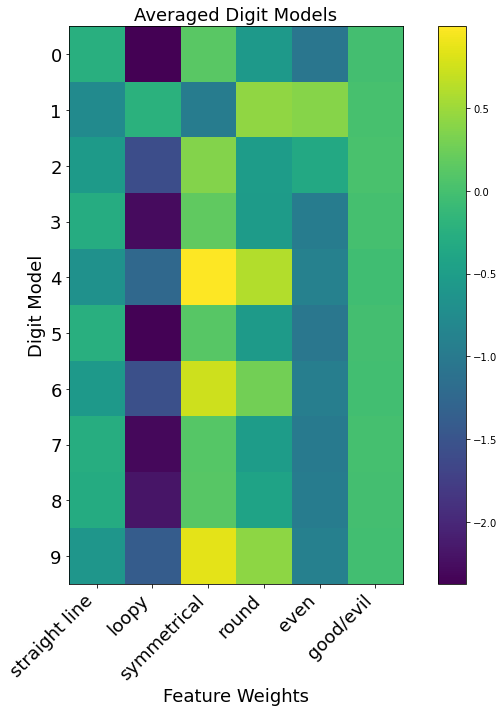

In [11]:
vals_beta = []
for val in range(10):
    val_beta = betas[vals_test == val].mean(axis=0)
    vals_beta.append(val_beta[0])

plt.figure(figsize=(10, 10))
plt.imshow(vals_beta)
plt.colorbar()
plt.title('Averaged Digit Models', fontsize=18)
plt.ylabel('Digit Model', fontsize=18)
plt.yticks(range(10), list(range(10)), fontsize=18)
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right', va='top', fontsize=18)
plt.xlabel('Feature Weights', fontsize=18)
plt.tight_layout()
plt.show()

/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


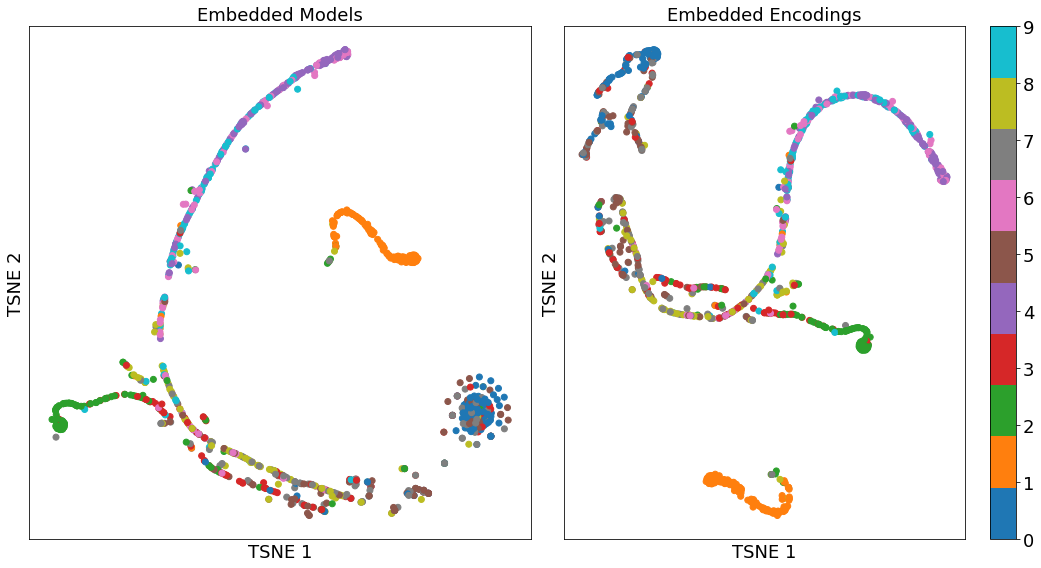

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
subtype_embeddings = tsne.fit_transform(encodings[1:])
beta_embeddings = tsne.fit_transform(betas[1:,0])
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].scatter(beta_embeddings[:,0], beta_embeddings[:,1], c=vals_test[1:], cmap='tab10')
axs[0].set_title('Embedded Models', fontsize=18)
axs[0].set_xlabel('TSNE 1', fontsize=18)
axs[0].set_xticks([])
axs[0].set_ylabel('TSNE 2', fontsize=18)
axs[0].set_yticks([])


cbar_fig = axs[1].scatter(subtype_embeddings[:,0], subtype_embeddings[:,1], c=vals_test[1:], cmap='tab10')
axs[1].set_title('Embedded Encodings', fontsize=18)
axs[1].set_xlabel('TSNE 1', fontsize=18)
axs[1].set_xticks([])
axs[1].set_ylabel('TSNE 2', fontsize=18)
axs[1].set_yticks([])

cbar = plt.colorbar(cbar_fig, ax=axs[1])
cbar.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.show()

# Contextualized Networks (coming soon)
How correlated are the digit qualities for similar handwritten contexts?

In [12]:
mlp_kwargs = {
    'width': 25,
    'layers': 2,
    'link_fn': lambda x: torch.nn.functional.softmax(x, dim=1)
}
link_fn = lambda x: 1 / (1 + torch.exp(-x))
cnet = ContextualizedCorrelation(
    C_train.shape[-1], 
    X_train.shape[-1], 
    link_fn=link_fn,
    context_encoder_kwargs = mlp_kwargs,
    task_encoder_kwargs = mlp_kwargs,
)
train_dataloader = cnet.dataloader(C_train, X_train, batch_size=1)
test_dataloader = cnet.dataloader(C_test, X_test, batch_size=1)

In [76]:
trainer = NetworkTrainer(max_epochs=1)
trainer.fit(cnet, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name      | Type               | Params
-------------------------------------------------
0 | metamodel | TasksplitMetamodel | 20.7 K
-------------------------------------------------
20.7 K    Trainable params
0         Non-trainable params
20.7 K    Total params
0.083     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider in

Training: 0it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
